<a href="https://colab.research.google.com/github/Txart/richards-nutrient/blob/master/ric_2d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Richards 2D

## Installing fipy

In [1]:
!pip install fipy

     |████████████████████████████████| 6.0MB 5.2MB/s 
  Created wheel for fipy: filename=FiPy-3.4.2.1-cp37-none-any.whl size=428098 sha256=bff61403b86056a65f6af23a65d6d58bbe40bbcf51a0fd08b1f24f175565ebc0
  Stored in directory: /root/.cache/pip/wheels/c0/7d/13/fb271572a3281d70dd3afeed715d37aef2298cdc54c449455c
Successfully built fipy


## Ready libraries

In [2]:
import matplotlib.pylab as plt
import math
from fipy import * 
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from scipy.special import erf

## Functions

In [3]:


def material_hydrol_properties(x=['mor']):
    """
    Hyrological properties of dirrerent materials
    Input:
        -x array of matrial names
    Output: (ThetaS and ThetaR in m3 m-3)
        van Genuchten water retention parameters as array [ThetaS, ThetaR, alpha, n] \n
        hydraulic conductivity (m/s)
    """
    vgen_dict={
    'mor':np.array([0.96,0.04,0.7827,1.4147]),
    'gravel':np.array([0.37,0.058,0.035,3.19]),
    'sand':np.array([0.37,0.058,0.035,3.19]),
    'loamy sand':np.array([0.39,0.074,0.035,2.39]),
    'silt':np.array([0.48,0.123,0.006,1.53]),
    }
    Ksat_dict={
    'mor':np.array([1.39e-3]),
    'gravel':np.array([3.0e-2]),
    'sand':np.array([2.78e-4]),
    'loamy sand':np.array([5.56e-5]),
    'silt':np.array([1.11e-5]),
    }
    n = np.shape(x)
    vgen=np.zeros((n[0],4)); Ksat=np.zeros(n[0])
    for k,xx in enumerate(x):
        vgen[k,:]= vgen_dict[xx]       
        Ksat[k] = Ksat_dict[xx]
    return vgen, Ksat
    
def peat_hydrol_properties(x, unit='g/cm3', var='bd', ptype='A'):
    """
    Peat water retention and saturated hydraulic conductivity as a function of bulk density
    Päivänen 1973. Hydraulic conductivity and water retention in peat soils. Acta forestalia fennica 129.
    see bulk density: page 48, fig 19; degree of humification: page 51 fig 21
    Hydraulic conductivity (cm/s) as a function of bulk density(g/cm3), page 18, as a function of degree of humification see page 51 
    input:
        - x peat inputvariable in: db, bulk density or dgree of humification (von Post)  as array \n
        - bulk density unit 'g/cm3' or 'kg/m3' \n
        - var 'db' if input variable is as bulk density, 'H' if as degree of humification (von Post) \n
        - ptype peat type: 'A': all, 'S': sphagnum, 'C': Carex, 'L': wood, list with length of x 
    output: (ThetaS and ThetaR in m3 m-3)
        van Genuchten water retention parameters as array [ThetaS, ThetaR, alpha, n] \n
        hydraulic conductivity (m/s)
    """
    #paras is dict variable, parameter estimates are stored in tuples, the model is water content = a0 + a1x + a2x2, where x is
    para={}                                                                     #'bd':bulk density in g/ cm3; 'H': von Post degree of humification
    para['bd'] ={'pF0':(97.95, -79.72, 0.0), 'pF1.5':(20.83, 759.69, -2484.3),
            'pF2': (3.81, 705.13, -2036.2), 'pF3':(9.37, 241.69, -364.6),
            'pF4':(-0.06, 249.8, -519.9), 'pF4.2':(0.0, 174.48, -348.9)}
    para['H'] ={'pF0':(95.17, -1.26, 0.0), 'pF1.5':(46.20, 8.32, -0.54),
            'pF2': (27.03, 8.14, -0.43), 'pF3':(17.59, 3.22, -0.07),
            'pF4':(8.81, 3.03, -0.10), 'pF4.2':(5.8, 2.27, -0.08)}
    
    intp_pF1={}                                                                 # interpolation functions for pF1        
    intp_pF1['bd'] = interp1d([0.04,0.08,0.1,0.2],[63.,84.,86.,80.],fill_value='extrapolate')
    intp_pF1['H'] = interp1d([1.,4.,6.,10.],[75.,84.,86.,80.],fill_value='extrapolate')
    
    #Saturatated hydraulic conductivity parameters
    Kpara ={'bd':{'A':(-2.271, -9.80), 'S':(-2.321, -13.22), 'C':(-1.921, -10.702), 'L':(-1.921, -10.702)}, 
            'H':{'A':(-2.261, -0.205), 'S':(-2.471, -0.253), 'C':(-1.850, -0.278), 'L':(-2.399, -0.124)}}
    
    vg_ini=(0.88,	0.09, 0.03, 1.3)                                              # initial van Genuchten parameters (porosity, residual water content, alfa, n)

    x = np.array(x)
    prs = para[var]; pF1=intp_pF1[var]
    if unit=='kg/m3'and var=='db': x=x/1000.
    if  np.shape(x)[0] >1 and len(ptype)==1:
        ptype=np.repeat(ptype, np.shape(x)[0])        
    vgen = np.zeros((np.size(x),4))
    Ksat = np.zeros((np.size(x)))
    
    #wcont = lambda x, (a0, a1, a2): a0 + a1*x + a2*x**2.
    wcont = lambda x, *a: a[0] + a[1]*x + a[2]*x**2.
    van_g = lambda pot, *p:   p[1] + (p[0] - p[1]) / (1. + (p[2] * pot) **p[3]) **(1. - 1. / p[3])   
    #K = lambda x, (a0, a1): 10.**(a0 + a1*x) / 100.   # to m/s   
    K = lambda x, *a: 10.**(a[0] + a[1]*x) / 100.   # to m/s   
    
    potentials =np.array([0.01, 10.,32., 100.,1000.,10000.,15000. ])
    
    wc = (np.array([wcont(x,*prs['pF0']), pF1(x), wcont(x,*prs['pF1.5']), wcont(x,*prs['pF2']),
               wcont(x,*prs['pF3']), wcont(x,*prs['pF4']),wcont(x,*prs['pF4.2'])]))/100.
        
    for i,s in enumerate(np.transpose(wc)):
        vgen[i],_= curve_fit(van_g,potentials,s, p0=vg_ini)                      # van Genuchten parameters
        
    for i, a, pt in zip(range(len(x)), x, ptype):
        Ksat[i] = K(a, *Kpara[var][pt])                                          # hydraulic conductivity (cm/s -> m/s) 
    
    return vgen, Ksat

def wrc(pF, x=None, var=None):
    """
    vanGenuchten-Mualem soil water retention curve\n
    IN:
        pF - dict['ThetaS': ,'ThetaR': ,'alpha':, 'n':,] OR
           - list [ThetaS, ThetaR, alpha, n]
        x  - soil water tension [m H2O = 0.1 kPa]
           - volumetric water content [vol/vol]
        var-'Th' is x=vol. wat. cont.
    OUT:
        res - Theta(Psii) or Psii(Theta)
    NOTE:\n
        sole input 'pF' draws water retention curve and returns 'None'. For drawing give only one pF-parameter set. 
        if several pF-curves are given, x can be scalar or len(x)=len(pF). In former case var is pF(x), in latter var[i]=pf[i,x[i]]
               
    Samuli Launiainen, Luke 2/2016
    """
    if type(pF) is dict: #dict input
        #Ts, Tr, alfa, n =pF['ThetaS'], pF['ThetaR'], pF['alpha'], pF['n']
        Ts=np.array(pF['ThetaS'].values()); Tr=np.array( pF['ThetaR'].values()); alfa=np.array( pF['alpha'].values()); n=np.array( pF['n'].values())
        m= 1.0 -np.divide(1.0,n)
    elif type(pF) is list: #list input
        pF=np.array(pF, ndmin=1) #ndmin=1 needed for indexing to work for 0-dim arrays
        Ts=pF[0]; Tr=pF[1]; alfa=pF[2]; n=pF[3] 
        m=1.0 - np.divide(1.0,n)
    elif type(pF) is np.ndarray:
        Ts, Tr, alfa, n = pF.T[0], pF.T[1], pF.T[2], pF.T[3]
        m=1.0 - np.divide(1.0,n)
    else:
        print ('Unknown type in pF')

    def theta_psi(x): #'Theta-->Psi'
        x=np.minimum(x,Ts) 
        x=np.maximum(x,Tr) #checks limits
        s= ((Ts - Tr) / (x - Tr))#**(1/m)
        Psi=-1e-2/ alfa*(s**(1/m)-1)**(1/n) # in m
        return Psi
        
    def psi_theta(x): # 'Psi-->Theta'
        Th = np.zeros(np.shape(x))
        compressibility = 1e-6
        x = 100.*x        
        #x=100*np.minimum(x,0) #cm
        #Th = Tr + (Ts-Tr)/(1+abs(alfa*x)**n)**m
        Th=np.where(x<0.0, Tr + (Ts-Tr)/(1+abs(alfa*x)**n)**m, x*compressibility+Ts) 
        return Th           
 
    if var is 'Th': y=theta_psi(x) #'Theta-->Psi'           
    else: y=psi_theta(x) # 'Psi-->Theta'          
    return y

def effSat(pF, x, var=None):                                                          #layer effective saturation [ratio, max 1]
    """
    Effective saturation
    IN:
        pF - dict['ThetaS': ,'ThetaR': ,'alpha':, 'n':,] OR
           - list [ThetaS, ThetaR, alpha, n]
        x - Theta [vol/vol] or Psi [m H2O]\n
        var = 'Psi' if x = Psi\n
    OUT
        es= (x-Tr)/(Ts-Tr)
    """                
    if type(pF) is dict: #dict input
        Ts=np.array(pF['ThetaS']); Tr=np.array( pF['ThetaR']); alfa=np.array( pF['alpha']); n=np.array( pF['n'])
    else: #list input
        pF=np.array(pF, ndmin=1) #ndmin=1 needed for indexing to work for 0-dim arrays
        Ts=pF[0]; Tr=pF[1]; alfa=pF[2]; n=pF[3] 
    eps=1e-10    
    if var is None or var is 'Th': #x=Th
        es=np.minimum((x-Tr)/(Ts-Tr + eps), 1.0)
    else:
        x=100*np.minimum(x,0) #cm
        x = Tr + (Ts-Tr)/(1+abs(alfa*x)**n)**(1.0-1.0/n) 
        es=np.minimum((x-Tr)/(Ts-Tr + eps), 1.0)
    return es

def hydrCond(pF, x=None, var=None, Ksat=1):
    """
    Hydraulic conductivity following vanGenuchten-Mualem \n
    IN:
        pF - dict or list
        x - Theta [vol/vol] or Psi [m H2O]
        var = 'Th' if x in [vol/vol]\n
        Ksat - saturated hydraulic conductivity [units]\n
    OUT:
        Kh - hydraulic conductivity ( if Ksat ~=1 then in [units], else relative [-]) \n
    """
    if type(pF) is dict: #dict input
        alfa=np.array( pF['alpha']); n=np.array( pF['n'])
        m= 1.0 -np.divide(1.0,n)
        
    else: #list input
        pF=np.array(pF, ndmin=1).T #ndmin=1 needed for indexing of 0-dim arrays
        alfa=pF[2]; n=pF[3]         
        m=1.0 - np.divide(1.0,n)

    def kRel(x):
        nm=(1 - abs(alfa*x)**(n-1) * (1 + abs(alfa*x)**n)**(-m))**2
        dn=(1 + abs(alfa*x)**n)**(m/2.0)
        r=nm/dn
        return r

    if x is None and np.size(alfa)==1:  #draws pf-curve
        xx=-np.logspace(-4,5,100) #cm
        yy=kRel(xx)
        fig=plt.figure()
        fig.suptitle('Hydr. cond. (vanGenuchten-Mualem)', fontsize=16)
        #ttext=str(pF).translate(None,"{}'")
        ttext= r'$K_{sat}=$' +str(Ksat) +r', $\alpha=$'+str(alfa)+ ', n='+str(n)

        plt.title(ttext, fontsize=14)
        plt.semilogx(-xx,yy,'g-')

        plt.ylabel(r'K_{sat}', fontsize=14) 
        plt.xlabel('$\psi$ $(cm)$', fontsize=14)

        del xx, yy
        return None
        
    elif x is None: 
        print ('hydrCond: To draw curve give only one pF -parameter set')
        return None
        
    # this computes and returns    
    x=np.array(x)
    if x is not None and var is 'Th': x=wrc(pF,x=x, var='Th')
        
    Kh=Ksat*kRel(100.0*x)
    
    return Kh
    
def diffWaterCap(pF, x):
    """
    Computes differential water capacity with respect to change in head between the iteration steps.
    x - psii in iteration
    xNew -  psii in present iteration
    """
    diff= 1e-6
    P1 = x-diff; P2=x+diff   
    t2 = wrc(pF, x=P2); t1 = wrc(pF, x=P1)
    return (t2 - t1) / (P2 - P1)

def air_pressure_to_mass(p,t,V):
    """
    pV=nRT, p=(nRT)/V, n=pV/(RT), 
    Input:
        p barometric pressure (Pa)
        t temperature in deg C
        V cell air volume in m3
    Output:
        air, kg in the cell air volume
    """ 
    R = 8.3144598  #universal gas constant, J K-1 mol-1
    #P=101300.0  #Pa N/m-2, tai kg m-1s-2
    Mair = 0.0289647 #kg/mol
    T=273.16+t
    n=p*V/(R*T)
    return n*Mair

def mass_to_air_pressure(m,t,V):
    """    
    p=nRT/V
    Input:
        m air mass in kg
        t temperature in deg C
        V cell air volume in m3
    Output:
        barometric pressure in Pa
    """    
    R = 8.3144598  #universal gas constant, J K-1 mol-1
    Mair = 0.0289647 #kg/mol
    n=m/Mair
    return n*R*(273.16+t)/V    

def air_conductivity(ea,tc):
    """
    Input:
        ea air filled porosity m3 m-3
        tc temperature in deg C
    Output:
        Ka air conductivity m s-1 
    """
    T=np.array(tc)+273.15
    ip = 10.**(3.166+2.761*np.log10(ea))*1e-12                                  # air permeability [µm2]: Laurén 1999 page 30
    airpara={'C': 120., 'T0': 291.15, 'mu0':18.27*1e-6}                         # dynamic viscosity mu , unit Pa*s  (https://en.wikipedia.org/wiki/Viscosity)         
    lam = (airpara['mu0']*(airpara['T0']+airpara['C']))/(airpara['T0']**(3./2.))
    mu = lam*(T**(3./2.))/(T+airpara['C'])
    return ip/mu

def Cair(tc,V):
    """
    storage coefficient for air dP/dm
    Input:
        tc, temperature in deg C
        V, cell air volume, m3
    Output:
        dP/dm
    """
    R = 8.3144598  #universal gas constant, J K-1 mol-1
    return R*(T+273.15)/V


    
#m=0.031; T=10.0; V=0.2*0.1; R=8.3144598; ea=0.32  
#print mass_to_air_pressure(m, T, V)
#print m*Cair(T,V)
#print air_conductivity(ea,T)/Cair(T,V)
#print mass_to_air_pressure(m,T,V)
#print peat_hydrol_properties([0.12,0.1])
#mat=np.repeat('mor',10)
#   print material_hydrol_properties(mat)

## Calculate

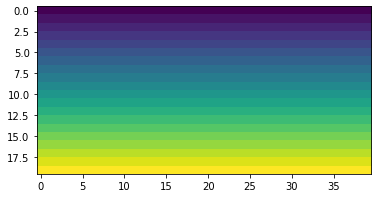

In [5]:
gwl=-0.9
spara = {
'nLyrs':20, 'dzLyr': 0.1, 'nCols':40, 'dyLyr':0.1, 'peat type':['C'], 
'vonP bottom': 5, 'vonP top': [5]
}

dz=np.ones(spara['nLyrs'])*spara['dzLyr']
z = np.cumsum(dz)-0.5*spara['dzLyr']
dy=np.ones(spara['nLyrs'])*spara['dyLyr']
y=np.cumsum(dy)-0.5*spara['dyLyr']

soilarray=np.ones((spara['nLyrs'],spara['nCols']))
vonP=soilarray*spara['vonP bottom']
ntop = len(spara['vonP top']); cols=spara['nCols']
vonP[0:ntop,:]=np.transpose(spara['vonP top']*np.ones((cols,1)))
pF, Ksat = peat_hydrol_properties(np.ravel(vonP), var='H', ptype=spara['peat type'])  #pF as flattened array


#-------------- construct model--------------------------------
mesh = Grid2D(nx=spara['nLyrs'],ny=spara['nCols'], dx=spara['dzLyr'], dy=spara['dyLyr'])                                                     # construct computation mesh
X,Y= mesh.cellCenters                                              #X is vertical direction, Y horizontal
Xf, Yf  = mesh.faceCenters                                                   

#bnd = X-0.9  #in m, negative downwards
bfleft = (mesh.exteriorFaces & (Yf > 1.0) & (Xf==0.))

tmp = np.array(bfleft)

#psi=np.ones(spara['nLyrs']*spara['nCols'])*-0.2
psi = X+gwl  #in m, negative downwards

theta = wrc(pF,psi,var='Psii') #m3 m-3
phi = CellVariable(name="psii, m H2O",                                          # response variable, temperature in nodes, deg C
                   mesh=mesh,
                   value=psi,
                   hasOld=True)

#phi.constrain(bnd, where=mesh.facesLeft)
#print (phi.value)
plt.imshow(np.reshape(np.array(phi.value), (40,20)).T)

0 3 7.636118011175684e-12 0.20608537893629375
1 3 6.337723596311694e-12 0.41261046764695664
2 3 5.238865889433743e-12 0.6194706415589835
3 3 4.3359830610368456e-12 0.8265855873608174
4 3 3.608023975452377e-12 1.0338943569569992
5 2 2.3080118756398554e-11 1.0325197100478078
6 2 1.5519835173410118e-11 1.0314758603371388
7 2 1.0748765242446075e-11 1.0306723174489107
8 2 7.683319173130172e-12 1.0300449641471587
9 2 5.652763172625815e-12 1.0295482757447516


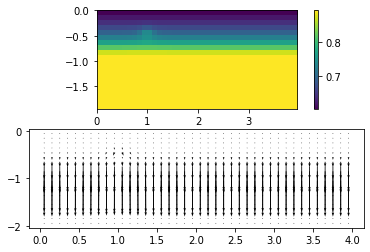

In [ ]:
Kc=CellVariable(mesh=mesh, value = hydrCond(pF, psi, var='Psii', Ksat=Ksat))
K=FaceVariable(mesh=mesh, value=Kc.harmonicFaceValue)
C = CellVariable(mesh=mesh, value= diffWaterCap(pF, psi))
Cf = FaceVariable(mesh=mesh, value=C.harmonicFaceValue)
Sc = CellVariable(mesh=mesh, value=0.0)
S=FaceVariable(mesh=mesh, value=0.0)

#mask = FaceVariable(mesh=mesh, value=mesh.facesLeft)
#phi.constrain(0., where=mask)
#phi.faceGrad.constrain(0, mesh.facesLeft)
#phi.faceGrad.constrain(0, mesh.facesRight)
#phi.faceGrad.constrain(0, mesh.facesTop)
#phi.faceGrad.constrain(0, mesh.facesBottom)
#phi.constrain(-5., where= (X > 0.5)&(Y==1.95))
#fig=plt.subplot(111)
#plt.imshow(phi.value)

hours =5.*1
dt = 60.*30*1.                                                       # dt in sec
#dt = 0.9*min(dz)**2/min(2*K/Cf) 

steps = int(hours*3600./ dt)                                      # time steps in computation
rainfall=np.zeros(steps)
dailyP=5.   #mm
half=int(steps/2)
rainfall[0:half] = dailyP/1000./86400. #mm/day->m->m/s
infil = np.zeros(spara['nLyrs'])

g = [1.,0.]                                                                         # gravity "vector" (not really needed in 1D)
#g=((1.,),(0.,))

eq = TransientTerm(coeff=C, var=phi) == (DiffusionTerm(coeff=K, var=phi)) - (K*g).divergence + Sc/mesh.cellVolumes                                # set governing equation

wini = sum(wrc(pF,x=np.ravel(phi.value))*mesh.cellVolumes)
wcontini=wrc(pF,x=np.ravel(phi.value))
for step in range(steps):
    phi.updateOld()                                                             # update temperature once in timestep
    infil[0]=rainfall[step]    
    for s in range(20):
        tmpK=hydrCond(pF, phi.value, var='Psii', Ksat=Ksat) 
        Kc.setValue(tmpK)
        K.setValue(Kc.harmonicFaceValue)        
        Sc.setValue(rainfall[step], where= (X==0.45)&(Y>0.9) & (Y <1.1))        
        C.setValue(diffWaterCap(pF, phi.value))
        Cf.setValue(C.harmonicFaceValue)    
        K.setValue(0.0, where=mesh.facesLeft)
        K.setValue(0.0, where=mesh.facesRight)
        #K.setValue(0.0, where=mesh.facesTop)
        #K.setValue(0.0, where=mesh.facesBottom)
        res=eq.sweep(var=phi,dt=dt)                              # implicit solution, iterate until convergence
        if res < 1e-10: break
    print (step, s, res, (sum(wrc(pF,x=phi.value)*mesh.cellVolumes)-wini)*1000.)
#phi.setValue(100., where=(X==0.05)&(Y==1.05))
theta = wrc(pF,phi.value,var='Psii')
p=np.reshape(theta,(spara['nCols'], spara['nLyrs']))
#print p    
wend = sum(wrc(pF,x=phi.value)*mesh.cellVolumes)
fig=plt.subplot(211)
plt.imshow(p.T, extent=[0, max(Y),-max(X),0])
plt.colorbar()
#plt.scatter(Y,-X)
G = CellVariable(mesh=mesh, value=phi.grad)
Gf= FaceVariable(mesh=mesh, value=G.arithmeticFaceValue)
Xf,Yf=mesh.faceCenters

#v_v = (Gf[0]-1.)*K
#v_h = (Gf[1])*K
#v_v = (G[0]-1.)*Kc
v_v = -(G[0])*Kc
v_h = -(G[1])*Kc

import matplotlib.cm as cm
colormap = cm.inferno
colors=np.sqrt(v_v**2+v_h**2)
plt.subplot(212)
#plt.quiver(Yf,-Xf,v_h,v_v, units='width')
plt.quiver(Y,-X,v_h,v_v,units='width')
#plt.quiver(Y,-X,v_h/v_h,v_v/v_v, color=colormap(colors),units='width')
#print (phi.value)